# MNIST with ConvNets

> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
</span>


In this lab we will solve the MNIST problem again, but this time with convolutional networks.
You will get a to try stacking of convolutional layers, max pooling and strided convolutions which are all important techniques in current convolutional layers network architectures.


### Dependancies and supporting functions


Loading dependancies and supporting functions by running the code block below.

In [62]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.datasets
import tensorflow as tf
import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 


## The MNIST data set

We load the MNIST dataset.
This time the data is keept as images (`shape = [28, 28, 1]`), and not flattended into vectors (`shape = [784]`).
This allows the convolutional network to take advantage of the structure of the data

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz

Information on dataset
    ----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 (28, 28, 1)
Image type		 <class 'numpy.ndarray'>
Image min/max value	 0.0 / 1.0
Label shape		 (10,)
Label type		 <class 'numpy.float64'>


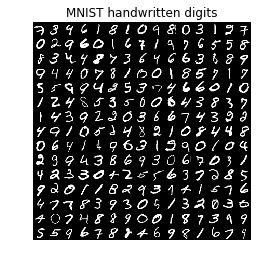

In [63]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

## Print dataset statistics and visualize
print('')
utils.mnist_summary(mnist_data)



## Building the model

We will use Keras layers, which are documented [here](https://keras.io/layers/about-keras-layers/)

In [64]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.contrib.layers import flatten # We use this flatten, as it works better than 
                                              # the Keras 'Flatten' for some reason


In [65]:
tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 5
kernel_size_1 = (4,4)
pool_size_1 = (3,3)

filters_2 = 2
kernel_size_2 = (3,3)
pool_size_2 = (2,2)


x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    #x = flatten(x)
    #print('Flatten \t', x.get_shape())
    
with tf.variable_scope('convLayer2'):
    conv2 = Conv2D(filters_2, kernel_size_2, strides = (1,1), padding = padding, activation = 'relu')
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())
    
    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())

with tf.variable_scope('denseLayer'):
    x = flatten(x)
    print('Flatten \t', x.get_shape())
    
    

with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 5)
pool1 		 (?, 10, 10, 5)
conv2 		 (?, 10, 10, 2)
pool2 		 (?, 5, 5, 2)
Flatten 	 (?, 50)
denseOut	 (?, 10)
Model consits of  687 trainable parameters.


In [66]:
## Launch TensorBoard, and visualize the TF graph
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)

In [67]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1]) # 1e-8, why?

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

    
with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

    
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [68]:
#Test the forward pass
x_batch, y_batch = mnist_data.train.next_batch(4)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

Forward pass successful!


## Training

In [ ]:
mnist_data.train._epochs_completed = 0 # reset trainning

#Training Loop
batch_size = 100
max_epochs = 5


valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size: # ??
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))


    except KeyboardInterrupt:
        pass


Begin training loop
Epoch 1 : Train Loss  0.752, Train acc  0.810,  Valid loss  0.533,  Valid acc  0.838
Epoch 2 : Train Loss  0.391, Train acc  0.900,  Valid loss  0.384,  Valid acc  0.883
Epoch 3 : Train Loss  0.555, Train acc  0.850,  Valid loss  0.305,  Valid acc  0.905


(<matplotlib.text.Text at 0x1c4c70c9c50>,
 (0.75, 1.03))

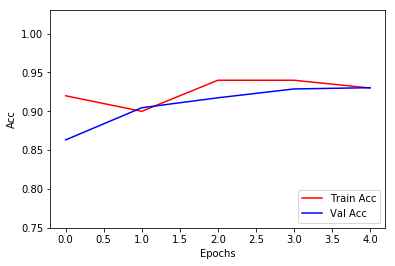

In [9]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

# Assignments

#### <span style="color:red"> EXE 1.1 </span> Manual calculations

![](images/conv_exe.png)



1. Manually convolve the input, and compute the convolved features. No padding and no strieds.
1. Perform `2x2` max pooling on the convolved features. Stride of 2.

___

<span style="color:blue"> Answer: </span>




### Resulting convolution

1-           
\begin{bmatrix}
{8} & {20}  \\
{14} & {25} 
\end{bmatrix} 
          
2- 25
       


#### <span style="color:red"> EXE 1.2 </span> Reducing the resolution
One of the important features of convolutional networks are their ability to reduce the spatial resolution, while retaining the important features.
Effectively this gives a local translational invariance and reduces the computation. 
This is most often done with **maxpooling** or by using strides.

1. Using only convolutional layers and pooling operations reduce the feature map size to `1x1xF`.
    * The number of feature maps, `F`, is up to you.

___

<span style="color:blue"> Write down what you did: </span>

Paste your code here
~~~~

tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 10
kernel_size_1 = (10,10)
pool_size_1 = (6,6)
strides_1 = (5,5)
strides_pool = None

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=strides_1, padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=strides_pool, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())


with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')



~~~~
Paste the trace of the tensors shape as it is propagated through the network here
~~~~
Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size

x_pl 		 (?, 28, 28, 1)

conv1 		 (?, 6, 6, 10)

pool1 		 (?, 1, 1, 10)

Flatten 	 (?, 10)

denseOut	 (?, 10)

Model consits of  1120 trainable parameters.
~~~~

#### <span style="color:red"> EXE 1.3 </span> Play around with the network.
The MNIST dataset is so easy to solve with convolutional networks that it isn't interesting to spend to much time on maximizing performance.
A more interesting question is *how few parameters can you solve it with?*

1. Try and minimize the number of parameters, while keeping validation accuracy about 95%. Try changing the

    * Number of layers
    * Number of filters
    * Kernel size
    * Pooling size
1. Once happy take note of the performance, number of parameters (printed automatically), and describe the network below.
___


<span style="color:blue"> Answer: </span>

So, I did a network with the following parameters:
~~~~

filters_1 = 5
kernel_size_1 = (4,4)
pool_size_1 = (3,3)

filters_2 = 2
kernel_size_2 = (3,3)
pool_size_2 = (2,2)

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 5)
pool1 		 (?, 10, 10, 5)
conv2 		 (?, 10, 10, 2)
pool2 		 (?, 5, 5, 2)
Flatten 	 (?, 50)
denseOut	 (?, 10)
Model consits of  687 trainable parameters.

~~~~


#### <span style="color:red"> EXE 1.4 </span> Comparing dense and convolutional networks

1. Now create a densely connected network (the ones from lab 1), and see how good performance you can get with a similar number of parameters.
___

<span style="color:blue"> Describe your findings: </span>


### Findings
The whole code for the dense Neural Net is down below

So, first of all, I could reduce the CNN number of parameters up to only 687. As for the dense NN, with only 10 neurons and 1 layer, I still had 7.960 params. The Dense network specs are as follows
~~~~
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_48 (Dense)             (None, 10)                7850      
_________________________________________________________________
activation_33 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 10)                110       
_________________________________________________________________
activation_34 (Activation)   (None, 10)                0         
=================================================================
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
~~~~

Even with less parameters to train, the CNN performed better achiving an accuracy of 0.935 while the dense network had 0.89

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
model = None

In [60]:
mnist_data_dense = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                      )



session = K.get_session()
if model is not None:
    model.reset_states()
    
    
#get trainning data
x_train = mnist_data_dense.train.images
targets_train = mnist_data_dense.train.labels

x_validation = mnist_data_dense.validation.images
targets_validation = mnist_data_dense.validation.labels


   
num_features = mnist_data_dense.train.images[0].shape[0]
num_classes = mnist_data_dense.train.labels[0].shape[0]
num_neurons = 10
num_layers = 1
batch_size = 100
num_epochs = 5

model = Sequential()

# The first layer needs to know the input_dim, so it is handled separately
print('Creating layer', 0)
model.add(Dense(units=num_neurons, input_dim=num_features))
model.add(Activation('relu'))

for i in range(1, num_layers):
    print('Creating layer', i)
    model.add(Dense(units=num_neurons, activation='relu'))

print('Creating output layer')
model.add(Dense(units=num_classes))

model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

print(model.summary())

train_history = model.fit(x_train, targets_train,
          validation_data = (x_validation,targets_validation),
          epochs=num_epochs, 
          batch_size=batch_size)

loss, accuracy = model.evaluate(x_validation, 
                                targets_validation, 
                                batch_size=128)
print()
print('Validation Loss:', loss)
print('Validation Accuracy', accuracy)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Creating layer 0
Creating output layer
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 10)                7850      
_________________________________________________________________
activation_33 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 10)                110       
_________________________________________________________________
activation_34 (Activation)   (None, 10)                0         
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
None
Train on 55000 samples, validate o

In [10]:
print(mnist_data.train)